# Detector simulation
In this notebook we load a track dataset generated by `edep-sim` and we calculate the ADC counts corresponding to each pixel. The result is exported to a HDF5 file.

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import consts
import importlib
importlib.reload(consts)

consts.load_detector_properties("../larndsim/detector_properties/singlecube.yaml","../larndsim/pixel_layouts/layout-singlecube.yaml")

In [3]:
from math import ceil

from larndsim import quenching, drifting, detsim, pixels_from_track, fee

importlib.reload(detsim)
importlib.reload(drifting)
importlib.reload(quenching)
importlib.reload(pixels_from_track)
importlib.reload(fee)

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D 
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import numba as nb

from numba import cuda

### Dataset import

First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [4]:
with h5py.File('edepsim_1M.h5', 'r') as f:
    tracks = np.array(f['segments'])

y_start = np.copy(tracks['y_start'] )
y_end = np.copy(tracks['y_end'])
y = np.copy(tracks['y'])

tracks['y_start'] = np.copy(tracks['z_start'])
tracks['y_end'] = np.copy(tracks['z_end'])
tracks['y'] = np.copy(tracks['z'])

tracks['z_start'] = y_start
tracks['z_end'] = y_end
tracks['z'] = y

In [5]:
selected_tracks = tracks[:100]

### Quenching and drifting
We calculate the number of electrons after recombination (`quenching` module) and the position and number of electrons after drifting (`drifting` module).

In [6]:
threadsperblock = 256
blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
quenching.quench[blockspergrid,threadsperblock](selected_tracks, consts.box)
drifting.drift[blockspergrid,threadsperblock](selected_tracks)

We find the pixels intersected by the projection of the tracks on the anode plane using the Bresenham's algorithm. We also take into account the neighboring pixels, due to the transverse diffusion of the charges.

In [7]:
longest_pix = ceil(max(selected_tracks["dx"])/consts.pixel_size[0])
max_radius = ceil(max(selected_tracks["tran_diff"])*5/consts.pixel_size[0])

MAX_PIXELS = (longest_pix*4+6)*max_radius*2
MAX_ACTIVE_PIXELS = longest_pix*2

active_pixels = np.full((selected_tracks.shape[0], MAX_ACTIVE_PIXELS, 2), -1, dtype=np.int32)
neighboring_pixels = np.full((selected_tracks.shape[0], MAX_PIXELS, 2), -1, dtype=np.int32)
n_pixels_list = np.zeros(shape=(selected_tracks.shape[0]))

threadsperblock = 128
blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
pixels_from_track.get_pixels[blockspergrid,threadsperblock](selected_tracks, 
                                                            active_pixels, 
                                                            neighboring_pixels, 
                                                            n_pixels_list,
                                                            max_radius+1)

In [8]:
shapes = neighboring_pixels.shape
joined = neighboring_pixels.reshape(shapes[0]*shapes[1],2)
unique_pix = np.unique(joined, axis=0)
unique_pix = unique_pix[(unique_pix[:,0] != -1) & (unique_pix[:,1] != -1),:] # This array contains a unique list of involved pixels

### Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [9]:
# Here we build a map between tracks and event IDs
unique_eventIDs = np.unique(selected_tracks['eventID'])
event_id_map = np.zeros_like(selected_tracks['eventID'])
for iev, evID in enumerate(selected_tracks['eventID']):
    event_id_map[iev] = np.where(evID == unique_eventIDs)[0]
d_event_id_map = cuda.to_device(event_id_map)

# Here we find the longest signal in time and we store an array with the start in time of each track
max_length = np.array([0])
track_starts = np.empty(selected_tracks.shape[0])
d_track_starts = cuda.to_device(track_starts)
threadsperblock = 128
blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
detsim.time_intervals[blockspergrid,threadsperblock](d_track_starts, max_length,  d_event_id_map, selected_tracks)

# Here we calculate the induced current on each pixel
signals = np.zeros((selected_tracks.shape[0], 
                    neighboring_pixels.shape[1], 
                    max_length[0]), dtype=np.float32)
threadsperblock = (4,4,4)
blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
d_signals = cuda.to_device(signals)

detsim.tracks_current[blockspergrid,threadsperblock](d_signals, 
                                                     neighboring_pixels, 
                                                     selected_tracks)

# Here we create a map between tracks and index in the unique pixel array
pixel_index_map = np.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)

for itr in range(neighboring_pixels.shape[0]):
    for ipix in range(neighboring_pixels.shape[1]):
        pID = neighboring_pixels[itr][ipix]
        if pID[0] >= 0 and pID[1] >= 0:
            try:
                index = np.where((unique_pix[:,0] == pID[0]) & (unique_pix[:,1] == pID[1]))
            except IndexError:
                print(index,"More pixels than maximum value")
            pixel_index_map[itr,ipix] = index[0]
            
# Here we combine the induced current on the same pixels by different tracks
d_pixel_index_map = cuda.to_device(pixel_index_map)
threadsperblock = (8,8,8)
blockspergrid_x = ceil(d_signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(d_signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(d_signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
pixels_signals = np.zeros((len(unique_pix),len(consts.time_ticks)*len(unique_eventIDs)*2))
d_pixels_signals = cuda.to_device(pixels_signals)
detsim.sum_pixel_signals[blockspergrid,threadsperblock](d_pixels_signals, 
                                                        d_signals, 
                                                        d_track_starts, 
                                                        d_pixel_index_map)

currents = np.sum(d_pixels_signals,axis=1)*consts.t_sampling/consts.e_charge

### 3D event display

/global/homes/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


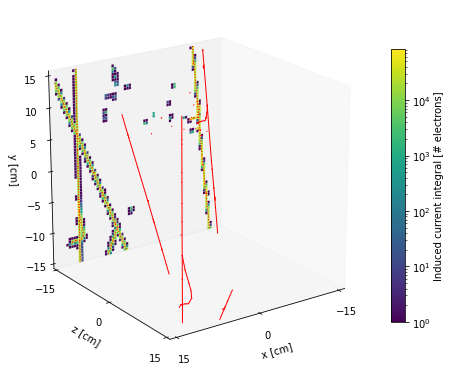

In [10]:
cmap = cm.Spectral_r
norm = mpl.colors.Normalize(vmin=0, vmax=256)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

cmap = cm.viridis
norm_curr = mpl.colors.LogNorm(vmin=1, vmax=max(currents))
m_curr = cm.ScalarMappable(norm=norm_curr, cmap=cmap)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for it,t in enumerate(selected_tracks):
    if it == 0:
        ax.plot((t["x_start"], t["x_end"]), 
            (t["z_start"], t["z_end"]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            alpha=1,
            zorder=10,
            label='Geant4 detector segment')
    else:
        ax.plot((t["x_start"], t["x_end"]), 
                (t["z_start"], t["z_end"]),
                (t["y_start"], t["y_end"]),
                c='r',
                lw=1,
                alpha=1,
                zorder=9999)
        
    ax.plot((t["x_start"], t["x_end"]), 
            (consts.module_borders[0][2][0], consts.module_borders[0][2][0]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            ls=':',
            alpha=1,
            zorder=9999)
        
for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p)
    pixel_plane = int(p[0] // consts.n_pixels[0])
    row = int(pixel_plane // 4)
    column = int(pixel_plane % 4)
    if currents[ip] > 0:
        rect = plt.Rectangle((x_rect-consts.pixel_size[0]/2, y_rect-consts.pixel_size[0]/2),
                             consts.pixel_size[0], consts.pixel_size[1],
                             linewidth=0.1, fc=m_curr.to_rgba(currents[ip]),
                             edgecolor='white', label=('Pixel' if ip == 5 else ''))
        ax.add_patch(rect)
        art3d.pathpatch_2d_to_3d(rect, z=consts.module_borders[pixel_plane][2][0], zdir="y")

# ax.set_ylim(consts.module_borders[pixel_plane][2][0],50)
ax.set_xlim(consts.module_borders[0][1][0],consts.module_borders[0][1][1])
ax.set_ylim(consts.module_borders[0][2][0],consts.module_borders[0][2][1])
ax.set_zlim(consts.module_borders[0][2][0],consts.module_borders[0][2][1])

ax.set_box_aspect((1, 1, 1))
ax.grid(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.view_init(20, 55)

ax.set_ylabel("z [cm]")
ax.set_xlabel("x [cm]")
ax.set_zlabel("y [cm]")
_ = plt.colorbar(m_curr,fraction=0.035, pad=0.05,label='Induced current integral [# electrons]')


### Electronics response and digitization 
Here we simulate the electronics response (the self-triggering cycle) and the signal digitization.

In [11]:
time_ticks = np.linspace(0,len(unique_eventIDs)*consts.time_interval[1]*2,d_pixels_signals.shape[1]+1)
integral_list = np.zeros((d_pixels_signals.shape[0], fee.MAX_ADC_VALUES))
adc_ticks_list = np.zeros((d_pixels_signals.shape[0], fee.MAX_ADC_VALUES))
TPB = 32
BPG = ceil(d_pixels_signals.shape[0] / TPB)
rng_states = cuda.random.create_xoroshiro128p_states(TPB * BPG, seed=0)

fee.get_adc_values[BPG,TPB](d_pixels_signals, 
                            time_ticks, 
                            integral_list, 
                            adc_ticks_list,
                            0,
                            rng_states)
adc_list = fee.digitize(integral_list)

### 2D event display with induced current and ADC counts

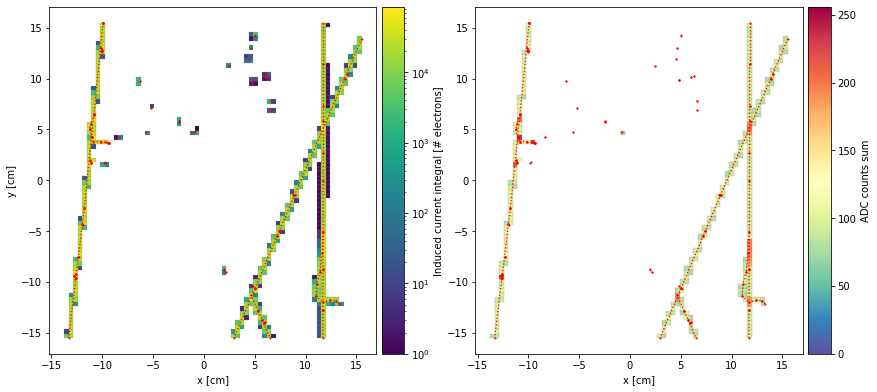

In [12]:
fig,ax = plt.subplots(1,2,figsize=(14,6.5))

for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p)
    pixel_plane = int(p[0] // consts.n_pixels[0])
    c = currents[ip]
    if c >=1:    
        rect = plt.Rectangle((x_rect-consts.pixel_size[0]/2, y_rect-consts.pixel_size[0]/2),
                             consts.pixel_size[0], consts.pixel_size[1],
                             linewidth=0.2, fc=m_curr.to_rgba(c),
                             edgecolor='grey')
        ax[0].add_patch(rect)

    a = adc_list[ip][adc_list[ip]>fee.digitize(0)]
    if len(a):    
        rect = plt.Rectangle((x_rect-consts.pixel_size[0]/2, y_rect-consts.pixel_size[0]/2),
                             consts.pixel_size[0], consts.pixel_size[1],
                             linewidth=0.2, fc=m.to_rgba(np.sum(a)),
                             edgecolor='grey')
        ax[1].add_patch(rect)
        
for it,t in enumerate(selected_tracks):
    ax[0].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1.25,
            ls=':',
            alpha=1,
            zorder=10)
    ax[1].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1.25,
            ls=':',
            alpha=1,
            zorder=10)
    ax[0].scatter((t["x_start"], t["x_end"]), 
                  (t["y_start"], t["y_end"]),
                  c='r', s=1, zorder=99999)
    ax[1].scatter((t["x_start"], t["x_end"]), 
                  (t["y_start"], t["y_end"]),
                  c='r', s=1, zorder=99999)       

ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[0].set_xlabel("x [cm]")
ax[1].set_xlabel("x [cm]")
ax[0].set_ylabel("y [cm]")

divider0 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m, ax=ax[1], cax=cax0, label='ADC counts sum')

divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m_curr, ax=ax[0], cax=cax1, label='Induced current integral [# electrons]')

plt.subplots_adjust(hspace=0.5)
fig.savefig("currentadc.pdf")

### Export result
As a last step we backtrack the ADC counts to the Geant4 tracks and we export the result in a HDF5 file.

In [13]:
track_pixel_map = np.full((unique_pix.shape[0],5),-1)
backtracked_id = np.full((adc_list.shape[0], adc_list.shape[1], track_pixel_map.shape[1]), -1)

detsim.get_track_pixel_map(track_pixel_map, unique_pix, neighboring_pixels)
detsim.backtrack_adcs(selected_tracks, adc_list, adc_ticks_list, track_pixel_map, event_id_map, backtracked_id)

In [14]:
importlib.reload(fee)
pc = fee.export_to_hdf5(adc_list, adc_ticks_list, unique_pix, backtracked_id, "test.h5")

Writing to HDF5...: 100%|██████████| 1542/1542 [00:00<00:00, 34690.44it/s]
